In [28]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs, stress_to_survival, survival_to_stress

In [19]:
ignore = ['huang_Flupyradifurone_2023', 'imrana_copper_2024', 'ayesha_chlorantran_2022_reference', 'ayesha_chlorantran_2022_agriculture', 'imrana_salt_2024', 'naemm_Clothianidin_2024_reference']

filter_func = lambda path : not any(i in path for i in ignore)

In [20]:
def predict_cleaned_curv(data : ExperimentData):
    
    
    
    concentration = pad_c0(data.main_series.concentration).copy()
    survival_tox_observerd = np.copy(data.main_series.survival_rate / data.meta.max_survival)
    
    if data.meta.hormesis_concentration is None:
    
        hormesis_index = detect_hormesis_index(survival_tox_observerd)
        
        if hormesis_index is None:
            hormesis_index = 1
    
    else:
        hormesis_index = np.argwhere(data.meta.hormesis_concentration == data.main_series.concentration)[0,0]
    
    func, _, popt = pred_surv_without_hormesis(concentration=concentration, surv_withhormesis=survival_tox_observerd, hormesis_index=hormesis_index)
    
    return func, hormesis_index, popt

def compute_normalised_curve(model : ModelPredictions):
    
    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100

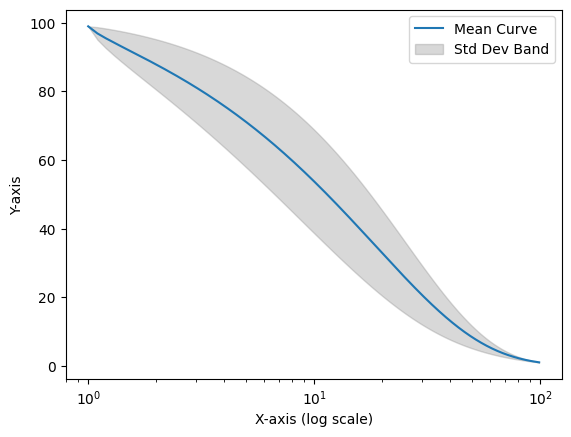

In [27]:
curves = []

for path, data in load_files(filter_func):
    
    cleaned_func, hormesis_index, popt = predict_cleaned_curv(data)
    inverse = lambda x: weibull_2param_inverse(x, *popt)
    def find_lc(lc):
        lc = 1 - lc/100
        return inverse(lc)
    
    lc1 = find_lc(1)
    lc99 = find_lc(99)

    x = np.linspace(lc1, lc99, 1000)
    
    curves.append(cleaned_func(x) * 100)

mean_curve = np.stack(curves).mean(0)
std_curve = np.stack(curves).std(0)

x = np.linspace(1, 99, 1000)

plt.plot(x, mean_curve, label="Mean Curve")
plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color='gray', alpha=0.3, label="Std Dev Band")

plt.xscale("log")
plt.xlabel('X-axis (log scale)')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

In [85]:
def get_sam_curve(stress :float) -> np.ndarray:
    
    return stress_to_survival( survival_to_stress(mean_curve / 100) + stress) * 100


def compute_lc_new(survival_curve: np.ndarray, lc : float):
    
    
    normed = survival_curve / 100
    normed /= normed.max()
    
    val = 1 - (lc / 100)
    
    arg = np.argmax(normed < val)
    if arg == 0: 
        return np.nan
    
    return float(x[arg])



# lc10, lc50 = [], []
# from tqdm import tqdm
# for val in tqdm(x):
    
#     curve = get_sam_curve(val / 100)
#     lc10.append(compute_lc_new(curve, 10))
#     lc50.append(compute_lc_new(curve, 50))

In [87]:
lc50

10.907907907907907

0.9
0.8962211436829653
8


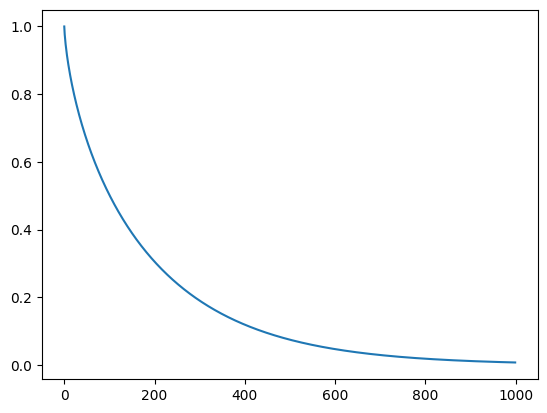

0.5
0.49988472278242907
101


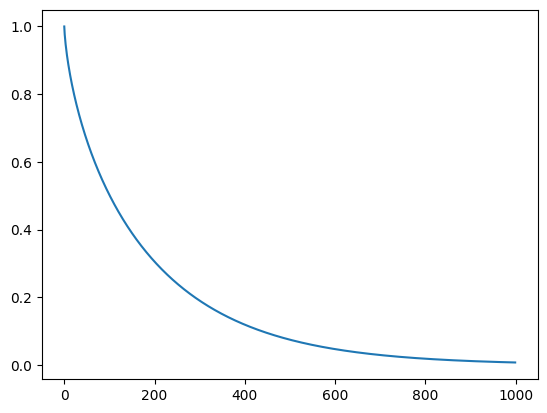

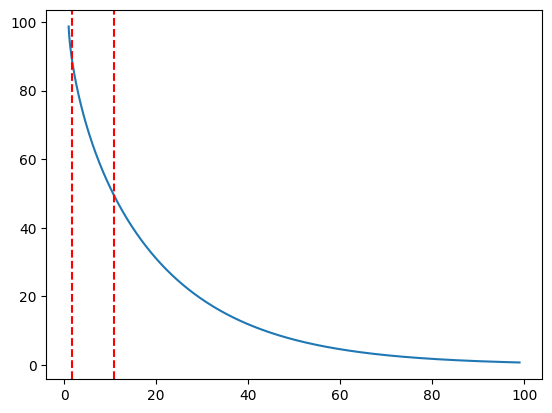

In [88]:
val = x[0] / 100
curve = get_sam_curve(val)

lc10 = compute_lc_new(curve, 10)
lc50 = compute_lc_new(curve, 50)
plt.plot(x, curve)
plt.axvline(lc10, color = "red", linestyle = "--")
plt.axvline(lc50, color = "red", linestyle = "--")
plt.show()

In [51]:
lc50

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 98.5095095095095,
 97.82282282282281,
 97.23423423423424,
 96.54754754754754,
 95.95895895895896,
 95.37037037037037,
 94.78178178178177,
 94.1931931931932,
 93.6046046046046,
 93.01601601601601,
 92.42742742742742,
 91.83883883883884,
 91.34834834834834,
 90.75975975975976,
 90.26926926926926,
 89.68068068068068,
 89.09209209209209,
 88.6016016016016,
 88.11111111111111,
 87.52252252252252,
 87.03203203203203,
 86.54154154154153,
 86.05105105105105,
 85.46246246246245,
 84.97197197197197,
 84.48148148148148,
 83.990990990991,
 83.5005005005005,
 83.01001001001,
 82.51951951951952,
 82.12712712712712,
 81.63663663663664,
 81.14614614614614,
 80.65565565565565,
 80.26326326326325,
 79.77277277277277,
 79.28228228228228,
 78.88988988988989,
 78.3993993993994,
 78.007007007007,
 77.51651651651652,
 77.12412412412412,
 76.73173173173173,
 76.24124124124124,
 75.84884884884885,
 75.45645645645645,
 74.96596

In [ ]:
    sam_lc50 = compute_lc_from_curve(
        stress_fit.concentration_curve,
        sam_sur,
        lc=50,
        survival_max=meta.max_survival,
        c0=stress_fit.optim_param["d"],
    )

In [ ]:
compute_lc_from_curve()

In [ ]:
mean_curve

In [24]:
dfs = []


for path, data, stress_name, stress_series in load_datapoints(filter=filter_func):
    meta = data.meta

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        stress_series,
        data.meta,
        settings=OLD_STANDARD,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
    
    main_lc10 = compute_lc(optim_param=main_fit.optim_param, lc=10)
    main_lc50 = compute_lc(optim_param=main_fit.optim_param, lc=50)

    dfs.append(
        {
            "title": path[:-4],
            "chemical": meta.chemical,
            "organism": meta.organism,
            "main_fit": main_fit,
            "stress_fit": stress_fit,
            "stress_name": stress_name,
            "main_lc10":main_lc10,
            "main_lc50":main_lc50,
            "stress_lc10" : lcs.stress_lc10,
            "stress_lc50" : lcs.stress_lc50,
            "sam_lc10" : lcs.sam_lc10,
            "sam_lc50" : lcs.sam_lc50,
        }
    )

df = pd.DataFrame(dfs)
df.head()

,title,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50
0,/home/felix/Desktop/sam/data/ayesha-cloth_Clot...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,22.882054,274.126159,15.299308,82.774078,2.402121,95.756849
1,/home/felix/Desktop/sam/data/ayesha-cloth_Clot...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_24,22.882054,274.126159,8.322573,22.965945,0.198204,30.426341
2,/home/felix/Desktop/sam/data/huang_imidachlopr...,Imidachloprid,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_15,2.883462,40.249261,0.377952,16.593701,0.043324,5.709334
3,/home/felix/Desktop/sam/data/naeem_Mix13_2024.,Mix13,Unknown,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Food_1%,0.069883,0.387973,0.000523,0.055558,0.000786,0.044721
4,/home/felix/Desktop/sam/data/naeem_Mix13_2024.,Mix13,Unknown,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_25,0.069883,0.387973,0.003105,0.110983,0.000976,0.050823


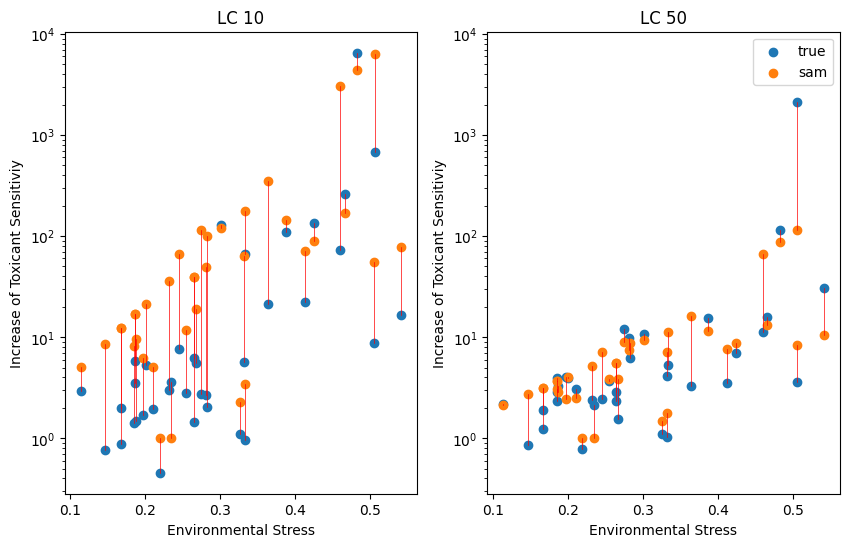

In [26]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50
df["sam_10_frac"] = df.main_lc10 / df.sam_lc10
df["sam_50_frac"] = df.main_lc50 / df.sam_lc50

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"


def subplot(true_col, sam_col):

    plt.scatter(df.stress_level, df[true_col], label = "true")
    plt.scatter(df.stress_level, df[sam_col], label = "sam")


    for i in range(len(df)):
        plt.plot(
            [df.stress_level[i], df.stress_level[i]],
            [df[true_col][i], df[sam_col][i]],
            color='red',
            linewidth=0.5
        )

    plt.yscale("log")
    plt.xlabel(x_name)
    plt.ylabel(y_name)

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")
subplot("true_10_frac", "sam_10_frac")

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")
subplot("true_50_frac", "sam_50_frac")

plt.legend()
plt.show()

In [ ]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50
df["sam_10_frac"] = df.main_lc10 / df.sam_lc10
df["sam_50_frac"] = df.main_lc50 / df.sam_lc50

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"


def subplot(true_col, sam_col):

    plt.scatter(df[true_col], df[sam_col], label = "true")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Measured Increase of Toxicant Sensitiviy")
    plt.ylabel("Predicted Increase of Toxicant Sensitiviy")

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")
subplot("true_10_frac", "sam_10_frac")

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")
subplot("true_50_frac", "sam_50_frac")

plt.legend()
plt.show()

In [ ]:


plot_frame = df[["stress_level", "10_frac", "50_frac"]].melt(id_vars = "stress_level", value_vars = ["10_frac", "50_frac"], var_name = "LC", value_name = y_name)
plot_frame.LC = plot_frame.LC.str.replace("_frac", "")
plot_frame = plot_frame.rename(columns={"stress_level": x_name})


g = sns.FacetGrid(plot_frame, hue = "LC",  height=6, aspect=1.5)
g.map(sns.scatterplot, x_name, y_name, )
g.set(yscale="log")
g.add_legend()
plt.show()